# JPMC Take-Home Project: Classification and Segmentation

## Required imports

In [45]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier, metrics
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score, confusion_matrix
from kmodes.kprototypes import KPrototypes
from sklearn.preprocessing import StandardScaler

## Directory paths

In [2]:
ROOT_DIR = Path().resolve().parent
CODE_DIR = ROOT_DIR / "code"
DATA_DIR = ROOT_DIR / "data"

## Read and preprocess dataset

In [75]:
# Read all the column names and eliminate the newline character from each line
with open(DATA_DIR / "census-bureau.columns", "r") as file:
    colnames = [x[:-1] for x in file.readlines()]

In [76]:
df = pd.read_csv(DATA_DIR / "census-bureau.data", names=colnames)

In [77]:
df.head()

,age,class of worker,detailed industry recode,detailed occupation recode,education,wage per hour,enroll in edu inst last wk,marital stat,major industry code,major occupation code,...,country of birth father,country of birth mother,country of birth self,citizenship,own business or self employed,fill inc questionnaire for veteran's admin,veterans benefits,weeks worked in year,year,label
0,73,Not in universe,0,0,High school graduate,0,Not in universe,Widowed,Not in universe or children,Not in universe,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,0,95,- 50000.
1,58,Self-employed-not incorporated,4,34,Some college but no degree,0,Not in universe,Divorced,Construction,Precision production craft & repair,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,52,94,- 50000.
2,18,Not in universe,0,0,10th grade,0,High school,Never married,Not in universe or children,Not in universe,...,Vietnam,Vietnam,Vietnam,Foreign born- Not a citizen of U S,0,Not in universe,2,0,95,- 50000.
3,9,Not in universe,0,0,Children,0,Not in universe,Never married,Not in universe or children,Not in universe,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,0,0,94,- 50000.
4,10,Not in universe,0,0,Children,0,Not in universe,Never married,Not in universe or children,Not in universe,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,0,0,94,- 50000.


In [78]:
# Value counts for all columns
for col in df.columns:
    print(df[col].value_counts())
    print()

age
34    3489
35    3450
36    3353
31    3351
33    3340
      ... 
85     423
86     348
87     301
88     241
89     195
Name: count, Length: 91, dtype: int64

class of worker
Not in universe                   100245
Private                            72028
Self-employed-not incorporated      8445
Local government                    7784
State government                    4227
Self-employed-incorporated          3265
Federal government                  2925
Never worked                         439
Without pay                          165
Name: count, dtype: int64

detailed industry recode
0     100684
33     17070
43      8283
4       5984
42      4683
45      4482
29      4209
37      4022
41      3964
32      3596
35      3380
39      2937
34      2765
44      2549
2       2196
11      1764
50      1704
40      1651
47      1644
38      1629
24      1503
12      1350
19      1346
30      1181
31      1178
25      1084
9        993
22       952
36       945
13       899
1        

In [79]:
# NaN values for all columns
df.isnull().sum()

age                                             0
class of worker                                 0
detailed industry recode                        0
detailed occupation recode                      0
education                                       0
wage per hour                                   0
enroll in edu inst last wk                      0
marital stat                                    0
major industry code                             0
major occupation code                           0
race                                            0
hispanic origin                               874
sex                                             0
member of a labor union                         0
reason for unemployment                         0
full or part time employment stat               0
capital gains                                   0
capital losses                                  0
dividends from stocks                           0
tax filer stat                                  0


In [80]:
df[df["hispanic origin"].isna()]["race"].value_counts()

race
White                          737
Black                           94
Amer Indian Aleut or Eskimo     15
Other                           14
Asian or Pacific Islander       14
Name: count, dtype: int64

In [81]:
df[~df["hispanic origin"].isna()]["race"].value_counts()

race
White                          166628
Black                           20321
Asian or Pacific Islander        5821
Other                            3643
Amer Indian Aleut or Eskimo      2236
Name: count, dtype: int64

In [82]:
df["label_binary"] = df["label"].apply(lambda x: 1 if "+" in x else 0)
df["label_binary"].value_counts()

label_binary
0    187141
1     12382
Name: count, dtype: int64

In [83]:
df.fillna({"hispanic origin": "Do not know"}, inplace=True)
df.isnull().sum()

age                                           0
class of worker                               0
detailed industry recode                      0
detailed occupation recode                    0
education                                     0
wage per hour                                 0
enroll in edu inst last wk                    0
marital stat                                  0
major industry code                           0
major occupation code                         0
race                                          0
hispanic origin                               0
sex                                           0
member of a labor union                       0
reason for unemployment                       0
full or part time employment stat             0
capital gains                                 0
capital losses                                0
dividends from stocks                         0
tax filer stat                                0
region of previous residence            

In [84]:
df["hispanic origin"].value_counts()

hispanic origin
All other                    171907
Mexican-American               8079
Mexican (Mexicano)             7234
Central or South American      3895
Puerto Rican                   3313
Other Spanish                  2485
Do not know                    1180
Cuban                          1126
Chicano                         304
Name: count, dtype: int64

In [85]:
# Extract labels, weights, and remaining features
X_cols = [c for c in df.columns if c not in ["weight", "label", "label_binary"]]
X = df[X_cols]
y = df["label_binary"]
w = df["weight"]

In [86]:
X.dtypes

age                                            int64
class of worker                               object
detailed industry recode                       int64
detailed occupation recode                     int64
education                                     object
wage per hour                                  int64
enroll in edu inst last wk                    object
marital stat                                  object
major industry code                           object
major occupation code                         object
race                                          object
hispanic origin                               object
sex                                           object
member of a labor union                       object
reason for unemployment                       object
full or part time employment stat             object
capital gains                                  int64
capital losses                                 int64
dividends from stocks                         

In [87]:
# Extract indices of categorical features
special_cols = ["detailed industry recode", "detailed occupation recode", "own business or self employed", "veterans benefits"]
special_col_indices = np.array([c in special_cols for c in X.columns])
categorical_features_indices = np.where(((X.dtypes != float) & (X.dtypes != int)) | special_col_indices)[0]

In [88]:
categorical_features_indices

array([ 1,  2,  3,  4,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 19, 20, 21,
       22, 23, 24, 25, 26, 27, 28, 30, 31, 32, 33, 34, 35, 36, 37])

## Classification

### Train-Val-Test Split

In [17]:
# Train : Validation : Test = 60 : 20 : 20
X_train, X_test, y_train, y_test, w_train, w_test = train_test_split(X, y, w, test_size=0.2, random_state=12)
X_train, X_val, y_train, y_val, w_train, w_val = train_test_split(X_train, y_train, w_train, test_size=0.25, random_state=34)

### Load or train CatBoostClassifier

In [18]:
clf = CatBoostClassifier()
clf.load_model("income_classifier.cbm")

**Note**: Uncomment the below two cells to retrain the model.

In [19]:
"""
clf = CatBoostClassifier(
    custom_loss=[metrics.Accuracy()],
    random_seed=335,
    logging_level='Silent'
)
"""

"\nclf = CatBoostClassifier(\n    custom_loss=[metrics.Accuracy()],\n    random_seed=335,\n    logging_level='Silent'\n)\n"

In [20]:
"""
clf.fit(
    X_train, y_train,
    sample_weight=w_train,
    cat_features=categorical_features_indices,
    logging_level='Verbose',
    eval_set=(X_val, y_val)
)
"""

"\nclf.fit(\n    X_train, y_train,\n    sample_weight=w_train,\n    cat_features=categorical_features_indices,\n    logging_level='Verbose',\n    eval_set=(X_val, y_val)\n)\n"

### Metrics

In [21]:
y_train_pred = clf.predict(X_train)
y_train_prob = clf.predict_proba(X_train)
y_val_pred = clf.predict(X_val)
y_val_prob = clf.predict_proba(X_val)
y_test_pred = clf.predict(X_test)
y_test_prob = clf.predict_proba(X_test)

#### Accuracy

In [22]:
print(f"Train accuracy: {accuracy_score(y_train, y_train_pred, sample_weight=w_train):.4f}")
print(f"Validation accuracy: {accuracy_score(y_val, y_val_pred, sample_weight=w_val):.4f}")
print(f"Test accuracy: {accuracy_score(y_test, y_test_pred, sample_weight=w_test):.4f}")

Train accuracy: 0.9631
Validation accuracy: 0.9569
Test accuracy: 0.9558


#### ROC-AUC

In [23]:
print(f"Train ROC-AUC: {roc_auc_score(y_train, y_train_prob[:,1], sample_weight=w_train):.4f}")
print(f"Validation ROC-AUC: {roc_auc_score(y_val, y_val_prob[:,1], sample_weight=w_val):.4f}")
print(f"Test ROC-AUC: {roc_auc_score(y_test, y_test_prob[:,1], sample_weight=w_test):.4f}")

Train ROC-AUC: 0.9632
Validation ROC-AUC: 0.9528
Test ROC-AUC: 0.9534


In [24]:
fpr_train, tpr_train, thresh_train = roc_curve(y_train, y_train_prob[:,1], sample_weight=w_train)
fpr_val, tpr_val, thresh_val = roc_curve(y_val, y_val_prob[:,1], sample_weight=w_val)
fpr_test, tpr_test, thresh_test = roc_curve(y_test, y_test_prob[:,1], sample_weight=w_test)

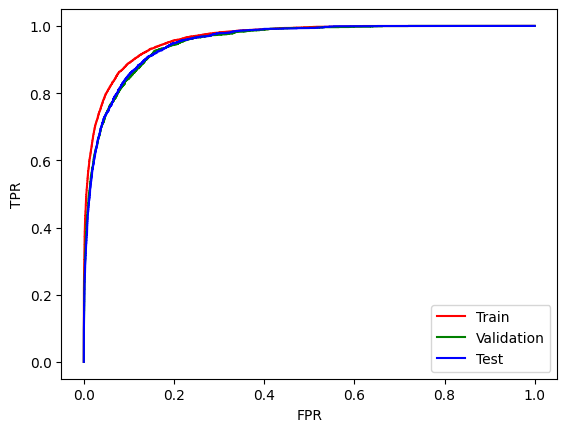

In [25]:
plt.figure(1)
plt.plot(fpr_train, tpr_train, "-r", label="Train")
plt.plot(fpr_val, tpr_val, "-g", label="Validation")
plt.plot(fpr_test, tpr_test, "-b", label="Test")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.legend()
plt.show()

#### Confusion Matrix, Precision, Recall

In [26]:
# Row: Actual, Column: Predicted
train_cm = confusion_matrix(y_train, y_train_pred, sample_weight=w_train, normalize="all")
val_cm = confusion_matrix(y_val, y_val_pred, sample_weight=w_val, normalize="all")
test_cm = confusion_matrix(y_test, y_test_pred, sample_weight=w_test, normalize="all")
print("Train confusion matrix:")
print(train_cm)
print("Validation confusion matrix:")
print(val_cm)
print("Test confusion matrix:")
print(test_cm)

Train confusion matrix:
[[0.92836341 0.00752964]
 [0.02939348 0.03471347]]
Validation confusion matrix:
[[0.92517945 0.01014331]
 [0.03296674 0.0317105 ]]
Test confusion matrix:
[[0.92498517 0.01176484]
 [0.03238755 0.03086244]]


In [27]:
labels = ["Train", "Validation", "Test"]
matrices = [train_cm, val_cm, test_cm]

for label, cm in zip(labels, matrices):
    tp = cm[1, 1]
    fp = cm[0, 1]
    fn = cm[1, 0]
    prec = tp/(tp+fp)
    rec = tp/(tp+fn)
    print(f"{label} data: Precision = {prec:.4f}, Recall = {rec:.4f}")

Train data: Precision = 0.8218, Recall = 0.5415
Validation data: Precision = 0.7576, Recall = 0.4903
Test data: Precision = 0.7240, Recall = 0.4879


In [28]:
# Changing the decision threshold
for p_thresh in np.arange(0.1, 0.6, 0.1):
    y_train_pred_thresh = (y_train_prob[:,1] >= p_thresh).astype(int)
    y_val_pred_thresh = (y_val_prob[:,1] >= p_thresh).astype(int)
    y_test_pred_thresh = (y_test_prob[:,1] >= p_thresh).astype(int)

    train_cm = confusion_matrix(y_train, y_train_pred_thresh, sample_weight=w_train, normalize="all")
    val_cm = confusion_matrix(y_val, y_val_pred_thresh, sample_weight=w_val, normalize="all")
    test_cm = confusion_matrix(y_test, y_test_pred_thresh, sample_weight=w_test, normalize="all")

    labels = ["Train", "Validation", "Test"]
    matrices = [train_cm, val_cm, test_cm]

    print(f"Threshold = {p_thresh:.1f}:")
    print("-------------------")
    for label, cm in zip(labels, matrices):
        tp = cm[1, 1]
        fp = cm[0, 1]
        fn = cm[1, 0]
        prec = tp/(tp+fp)
        rec = tp/(tp+fn)
        print(f"{label} data: Precision = {prec:.4f}, Recall = {rec:.4f}")
    print()

Threshold = 0.1:
-------------------
Train data: Precision = 0.4060, Recall = 0.8733
Validation data: Precision = 0.3882, Recall = 0.8276
Test data: Precision = 0.3767, Recall = 0.8452

Threshold = 0.2:
-------------------
Train data: Precision = 0.5532, Recall = 0.7787
Validation data: Precision = 0.5212, Recall = 0.7240
Test data: Precision = 0.5048, Recall = 0.7352

Threshold = 0.3:
-------------------
Train data: Precision = 0.6648, Recall = 0.6961
Validation data: Precision = 0.6164, Recall = 0.6369
Test data: Precision = 0.5989, Recall = 0.6468

Threshold = 0.4:
-------------------
Train data: Precision = 0.7508, Recall = 0.6119
Validation data: Precision = 0.6981, Recall = 0.5587
Test data: Precision = 0.6664, Recall = 0.5740

Threshold = 0.5:
-------------------
Train data: Precision = 0.8218, Recall = 0.5415
Validation data: Precision = 0.7576, Recall = 0.4903
Test data: Precision = 0.7240, Recall = 0.4879



#### Feature Importance

In [29]:
feature_importance = pd.DataFrame(np.array(clf.get_feature_importance(prettified=True)), columns=["feature", "importance"])
feature_importance["importance"] = feature_importance["importance"].apply(lambda x: np.round(x, 3))
feature_importance

,feature,importance
0,age,12.298
1,weeks worked in year,9.575
2,hispanic origin,9.077
3,family members under 18,9.054
4,veterans benefits,9.012
5,education,6.062
6,sex,4.859
7,detailed occupation recode,4.640
8,marital stat,4.387
9,tax filer stat,4.148


In [30]:
# Uncomment this line to save a new model (will overwrite the existing model)
# clf.save_model("income_classifier.cbm")

## Segmentation

### Additional Preprocessing

In [117]:
numerical_features_indices = np.array([i for i in range(len(X.columns)) if i not in categorical_features_indices])

In [118]:
numerical_features_indices

array([ 0,  5, 16, 17, 18, 29, 38, 39])

In [119]:
# Collapse rare categories
categorical_columns = X.columns[categorical_features_indices]
X_seg = X.copy()

for col in categorical_columns:
    X_seg[col] = X_seg[col].where(
        X_seg[col].isin(X_seg[col].value_counts().nlargest(20).index),
        "Other"
    )

    print(X_seg[col].value_counts())

class of worker
Not in universe                   100245
Private                            72028
Self-employed-not incorporated      8445
Local government                    7784
State government                    4227
Self-employed-incorporated          3265
Federal government                  2925
Never worked                         439
Without pay                          165
Name: count, dtype: int64
detailed industry recode
0        100684
Other     20327
33        17070
43         8283
4          5984
42         4683
45         4482
29         4209
37         4022
41         3964
32         3596
35         3380
39         2937
34         2765
44         2549
2          2196
11         1764
50         1704
40         1651
47         1644
38         1629
Name: count, dtype: int64
detailed occupation recode
0        100684
Other     25557
2          8756
26         7887
19         5413
29         5105
36         4145
34         4025
10         3683
16         3445
23         3392

In [120]:
for col in categorical_columns:
    X_seg[col] = X_seg[col].astype(str)

In [121]:
X_seg[numeric_columns] = X_seg[numeric_columns].apply(pd.to_numeric, errors="coerce")

In [122]:
# Scale numeric features
numeric_columns = X_seg.columns[numerical_features_indices]
scaler = StandardScaler()
X_seg[numeric_columns] = scaler.fit_transform(X_seg[numeric_columns])

In [123]:
X_seg_np = X_seg.to_numpy()

### Modeling - K-Prototypes (a generalization of K-Means for mixed numeric and categorical data)

First we try this method with an arbitrary value of K (say 8).

In [103]:
kp = KPrototypes(
    n_clusters=8,
    init="Huang",
    n_init=1,
    verbose=1,
    random_state=1102
)

kp.fit_predict(X_seg_np, categorical=categorical_features_indices.tolist(), sample_weight=w)
print(kp.cost_)

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 53797, ncost: 2599322530.1492667
Run: 1, iteration: 2/100, moves: 10983, ncost: 2563653898.503117
Run: 1, iteration: 3/100, moves: 2513, ncost: 2561804348.7449045
Run: 1, iteration: 4/100, moves: 862, ncost: 2560909240.6273475
Run: 1, iteration: 5/100, moves: 313, ncost: 2561447630.0709524
2561447630.0709524


To interpret our result, we can extract the cluster centroids from the fitted model, and convert them to a pandas DataFrame.

In [111]:
reordered_columns = numeric_columns.tolist() + categorical_columns.tolist()
prototypes = kp.cluster_centroids_
proto_df = pd.DataFrame(
    prototypes,
    columns=reordered_columns
)
proto_df

,age,wage per hour,capital gains,capital losses,dividends from stocks,num persons worked for employer,weeks worked in year,year,class of worker,detailed industry recode,...,live in this house 1 year ago,migration prev res in sunbelt,family members under 18,country of birth father,country of birth mother,country of birth self,citizenship,own business or self employed,fill inc questionnaire for veteran's admin,veterans benefits
0,-0.6999499782467675,-0.15230242507324032,-0.0753273070537946,-0.11422611376368418,-0.07736053703652579,-0.6054314204518573,-0.7392489613782249,-0.8323080388791749,Not in universe,0,...,Yes,Not in universe,Both parents present,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,0
1,0.5439904468682033,-0.07142393195171741,3.0969293170121195,-0.004156385428969555,3.317015138942089,0.0762022687540134,0.16431936197548425,0.042090890714577674,Not in universe,0,...,Not in universe under 1 year old,?,Not in universe,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2
2,0.16503660046829186,-0.012235538651938988,-0.013137860041611498,-0.13229794606725223,-0.05271901668335047,0.8233590134314693,0.9301413820115408,0.9729247103081178,Private,Other,...,Not in universe under 1 year old,?,Not in universe,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2
3,0.24839137215357748,0.0270029941969453,-0.019310985939392192,-0.1761014115223693,-0.06561335942025366,1.0411675726232998,1.2704976433426634,-1.2918236555527862,Private,Other,...,Yes,Not in universe,Not in universe,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2
4,1.2195828396951713,-0.2598181972562276,-0.14006555636654078,16.22073717672375,0.8795248360028111,0.23470770063770294,0.21846248133675908,0.26903030004593187,Not in universe,0,...,Not in universe under 1 year old,?,Not in universe,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2
5,-1.0500788805800803,-0.18958058473877232,-0.09109565050485924,-0.13580558770154294,-0.09672134469810861,-0.761869248176682,-0.909277552221487,0.9902294821465832,Not in universe,0,...,Not in universe under 1 year old,?,Both parents present,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,0
6,0.29271084404941955,2.5568079555304313,-0.0397822244162489,3.029376204826562,0.01962256096721875,0.7846668149692235,0.8324853020652982,0.0548605491970771,Private,Other,...,Not in universe under 1 year old,?,Not in universe,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2
7,1.5173227872901138,-0.20779297058048216,-0.06895728930468295,-0.14146625836430732,0.0009587112721726871,-0.8221824900961753,-0.9679174729198308,0.18361839752912096,Not in universe,0,...,Not in universe under 1 year old,?,Not in universe,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2


In [116]:
for col in numeric_columns:
    proto_df[col] = proto_df[col].astype(float)

proto_df.dtypes

age                                           float64
wage per hour                                 float64
capital gains                                 float64
capital losses                                float64
dividends from stocks                         float64
num persons worked for employer               float64
weeks worked in year                          float64
year                                          float64
class of worker                                object
detailed industry recode                       object
detailed occupation recode                     object
education                                      object
enroll in edu inst last wk                     object
marital stat                                   object
major industry code                            object
major occupation code                          object
race                                           object
hispanic origin                                object
sex                         

Notice that all the numeric values in the cluster centroids are all scaled (because of the `StandardScaler` that we applied). To make them interpretable, we need to use the `inverse_transform()` method on these values.

In [124]:
proto_df[numeric_columns] = scaler.inverse_transform(proto_df[numeric_columns])
proto_df

,age,wage per hour,capital gains,capital losses,dividends from stocks,num persons worked for employer,weeks worked in year,year,class of worker,detailed industry recode,...,live in this house 1 year ago,migration prev res in sunbelt,family members under 18,country of birth father,country of birth mother,country of birth self,citizenship,own business or self employed,fill inc questionnaire for veteran's admin,veterans benefits
0,18.877727,13.559617,80.867495,6.256194,44.033951,0.524263,5.128775,94.083518,Not in universe,0,...,Yes,Not in universe,Both parents present,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,0
1,46.631082,35.792772,14982.604871,36.183685,6779.013933,2.136408,27.186167,94.520717,Not in universe,0,...,Not in universe under 1 year old,?,Not in universe,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2
2,38.176304,52.063410,373.003636,1.342540,92.926638,3.903523,45.880976,94.986134,Private,Other,...,Not in universe under 1 year old,?,Not in universe,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2
3,40.036019,62.849917,344.005257,-10.567436,67.342216,4.418666,54.189558,93.853760,Private,Other,...,Yes,Not in universe,Not in universe,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2
4,61.704115,-15.996014,-223.241694,4447.663240,1942.646376,2.511292,28.507878,94.634187,Not in universe,0,...,Not in universe under 1 year old,?,Not in universe,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2
5,11.066058,3.312008,6.795394,0.388827,5.619037,0.154269,0.978135,94.994786,Not in universe,0,...,Not in universe under 1 year old,?,Both parents present,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,0
6,41.024823,758.282587,247.841215,860.988295,236.463808,3.812011,43.497051,94.527102,Private,Other,...,Not in universe under 1 year old,?,Not in universe,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2
7,68.346944,-1.694499,110.790778,-1.150286,199.431768,0.011621,-0.453350,94.591481,Not in universe,0,...,Not in universe under 1 year old,?,Not in universe,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2


To choose K, we try to make an elbow plot for K between 2 and 10. (**Note**: the below cell may take an hour or two to run.)

K = 2:
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 28878, ncost: 3989564630.390798
Run: 1, iteration: 2/100, moves: 17493, ncost: 3949779372.810847
Run: 1, iteration: 3/100, moves: 16658, ncost: 3878461340.4443583
Run: 1, iteration: 4/100, moves: 5716, ncost: 3876799471.1708884
Run: 1, iteration: 5/100, moves: 168, ncost: 3876797166.210605
Run: 1, iteration: 6/100, moves: 9, ncost: 3876797075.249828
Run: 1, iteration: 7/100, moves: 3, ncost: 3876797097.0554814

K = 3:
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 33467, ncost: 3823884831.7008677
Run: 1, iteration: 2/100, moves: 18226, ncost: 3797095857.1546426
Run: 1, iteration: 3/100, moves: 7043, ncost: 3775106483.717683
Run: 1, iteration: 4/100, moves: 5557, ncost: 3768864667.040926
Run: 1, iteration: 5/100, moves: 675, ncost: 3768781774.3533845
Run: 1, iteration: 6/100, moves: 88, ncost: 3768923857

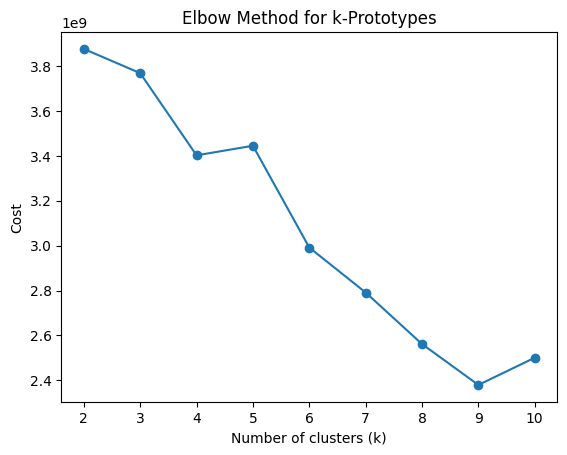

In [125]:
costs = []
k_list = range(2, 11)
kp_saved = []

for k in k_list:
    kp_elbow = KPrototypes(
        n_clusters=k,
        init="Huang",
        n_init=1,
        verbose=1,
        random_state=1102
    )
    print(f"K = {k}:")
    kp_elbow.fit_predict(X_seg_np, categorical=categorical_features_indices.tolist(), sample_weight=w)
    print()
    
    kp_saved.append(kp_elbow)
    costs.append(kp_elbow.cost_)

plt.figure(2)
plt.plot(k_list, costs, marker='o')
plt.xlabel("Number of clusters (k)")
plt.ylabel("Cost")
plt.title("Elbow Method for k-Prototypes")
plt.show()

Let us see how the clusters for K = 9 turned out:

In [126]:
prototypes = kp_saved[-2].cluster_centroids_
proto_df = pd.DataFrame(
    prototypes,
    columns=reordered_columns
)

for col in numeric_columns:
    proto_df[col] = proto_df[col].astype(float)

proto_df[numeric_columns] = scaler.inverse_transform(proto_df[numeric_columns])
proto_df

,age,wage per hour,capital gains,capital losses,dividends from stocks,num persons worked for employer,weeks worked in year,year,class of worker,detailed industry recode,...,live in this house 1 year ago,migration prev res in sunbelt,family members under 18,country of birth father,country of birth mother,country of birth self,citizenship,own business or self employed,fill inc questionnaire for veteran's admin,veterans benefits
0,45.436066,27.011373,23637.653085,16.302097,3597.740957,2.653725,35.447007,94.548596,Private,0,...,Not in universe under 1 year old,?,Not in universe,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2
1,73.941843,-9.792076,67.367554,6.247533,371.751909,-0.275649,-3.731418,94.588444,Not in universe,0,...,Not in universe under 1 year old,?,Not in universe,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2
2,58.867963,90.972620,17828.905193,228.785111,58626.489838,2.286205,32.244752,94.573676,Not in universe,0,...,Not in universe under 1 year old,?,Not in universe,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2
3,10.247100,0.216648,-14.619076,-0.212228,-2.266514,0.037112,-0.302176,95.019341,Not in universe,0,...,Not in universe under 1 year old,?,Both parents present,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,0
4,38.252797,1118.204212,290.628117,33.543332,98.112555,4.127228,46.463347,94.455310,Private,Other,...,Yes,Not in universe,Not in universe,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2
5,16.329992,5.363283,18.516611,3.891106,20.708196,0.291525,2.088101,94.009863,Not in universe,0,...,Yes,Not in universe,Both parents present,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,0
6,53.681613,13.467485,-295.785222,3637.159911,1048.510242,4.580817,56.029042,94.548004,Private,Other,...,Not in universe under 1 year old,?,Not in universe,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2
7,37.221293,32.285325,319.656384,31.009876,143.117356,3.358410,39.431700,94.857971,Private,Other,...,Not in universe under 1 year old,?,Not in universe,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2
8,41.090850,-8.785007,262.989680,28.896743,90.693411,4.760777,58.663042,93.766481,Private,Other,...,Yes,Not in universe,Not in universe,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2


In [128]:
# Uncomment to save the centroids
# proto_df.to_csv("cluster_centroids.csv")

It appears that some of the clusters have very similar attributes, so maybe a smaller value of K would be better from a segmentation point of view. Let us try K = 4 (there was a "local minima" in the above plot at this value):

In [129]:
prototypes_2 = kp_saved[2].cluster_centroids_
proto_df_2 = pd.DataFrame(
    prototypes_2,
    columns=reordered_columns
)

for col in numeric_columns:
    proto_df_2[col] = proto_df_2[col].astype(float)

proto_df_2[numeric_columns] = scaler.inverse_transform(proto_df_2[numeric_columns])
proto_df_2

,age,wage per hour,capital gains,capital losses,dividends from stocks,num persons worked for employer,weeks worked in year,year,class of worker,detailed industry recode,...,live in this house 1 year ago,migration prev res in sunbelt,family members under 18,country of birth father,country of birth mother,country of birth self,citizenship,own business or self employed,fill inc questionnaire for veteran's admin,veterans benefits
0,16.639203,14.321359,98.390423,9.488356,46.013435,0.600408,6.358946,94.555405,Not in universe,0,...,Not in universe under 1 year old,?,Both parents present,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,0
1,42.670863,177.808602,1811.682597,91.976273,107.335661,5.618124,66.601802,95.346796,Private,Other,...,Not in universe under 1 year old,?,Not in universe,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2
2,80.633489,-20.471836,328.324928,44.692427,1665.029092,-0.543091,-6.866911,95.162210,Not in universe,0,...,Not in universe under 1 year old,?,Not in universe,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2
3,43.168801,73.962105,347.496472,49.986570,151.941269,2.682084,31.922006,94.043820,Private,0,...,Yes,Not in universe,Not in universe,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2


In [131]:
# Uncomment to save the centroids
# proto_df_2.to_csv("cluster_centroids_2.csv")

## References
1. [https://catboost.ai/docs/en/concepts/tutorials](https://catboost.ai/docs/en/concepts/tutorials)
2. [https://github.com/catboost/tutorials](https://github.com/catboost/tutorials)
3. [https://github.com/nicodv/kmodes/blob/master/kmodes/kprototypes.py](https://github.com/nicodv/kmodes/blob/master/kmodes/kprototypes.py)
4. [https://antonsruberts.github.io/kproto-audience/](https://antonsruberts.github.io/kproto-audience/)